# code2vec using Embeddings and NN

We are going to represent programs as token vectors and learn their representations using embeddings

We are going to create a prediction problem and try to predict whether the program submitted with be considered as correct, i.e. the program pass the testcases specified by the lecturer. Creating a prediction problem to learn representations of the data is a useful approach. There is no easy way to represent these programs so we are going to learn these representations. 
 

* https://code.google.com/archive/p/word2vec/

* https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

* https://www.cse.iitb.ac.in/~pb/papers/bionlp-acl17-medical-coding.pdf

* https://github.com/sloomba/protein2vec

* https://github.com/samiroid/usr2vec

* https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

* http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

* Topic Modelling for Humans: https://radimrehurek.com/gensim/

* https://spacy.io/models/

* https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/

* Code2Vec https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8031179&tag=1, https://arxiv.org/pdf/1803.09473.pdf, https://code2vec.org/

* From People2Vec to Emotional AI: http://people2vec.org/

* Using Word2vec for Music Recommendations: https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

* Source code identifier embeddings: https://blog.sourced.tech/post/id2vec/

* Recommending Recommendation Systems: https://gab41.lab41.org/recommending-recommendation-systems-cc39ace3f5c1, https://github.com/Lab41/Misc/blob/master/blog/python2vec/Python2Vec%20Example.ipynb

* Python2Vec: Word Embeddings for Source Code: https://gab41.lab41.org/python2vec-word-embeddings-for-source-code-3d14d030fe8f

* Anything2Vec: https://gab41.lab41.org/anything2vec-e99ec0dc186

* AutoKeras: https://towardsdatascience.com/autokeras-the-killer-of-googles-automl-9e84c552a319, https://autokeras.com/

* Learning Program Embeddings to Propagate Feedback on Student Code: https://web.stanford.edu/~cpiech/bio/papers/programEncoding.pdf, https://github.com/chrispiech/refactoredEncoder

* Research at Code.org: https://code.org/research

* Cheatsheet: https://startupsventurecapital.com/essential-cheat-sheets-for-machine-learning-and-deep-learning-researchers-efb6a8ebd2e5

* DCU Deep Learning Summer School: https://telecombcn-dl.github.io/2018-dlcv/, https://www.slideshare.net/xavigiro/d1l2-the-neural-network-zoo-upc-2018-deep-learning-for-computer-vision

* Embeddings: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## VECTORIZE

**Programming data**: Student develop programs locally for the laboratory sheets of computer programming courses at our university. These programs are submitted by them to an automatic grading platform that runs some test cases specified by the lecturer on each program. A JSON output for those testcases and whether the program passed them or not along with the actual code is stored.

In [3]:
!ls data/raw/programming_data.json

data/raw/programming_data.json


In [4]:
dataframe = pd.read_json('data/raw/programming_data.json')

In [5]:
dataframe.head(2)

,academic_year_0,academic_year_1,correct,date,extension,ip,module,task,upload,user
0,2016,2017,True,2016-09-19 14:11:41,py,,ca277,add.py,#!/usr/bin/env python\n\na = int(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c
1,2016,2017,True,2016-09-19 14:17:33,py,,ca277,concat-lines.py,#!/usr/bin/env python\n\na = str(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c


In [6]:
'{:,}'.format(len(dataframe))

'591,707'

Grab only code submissions from Python modules:

In [7]:
PYTHON_MODULES = [
    'ca116', 
    'ca117', 
    'ca177', 
    'ca277', 
    'ca278',
]

In [8]:
dataframe = dataframe[dataframe['module'].isin(PYTHON_MODULES)]

In [9]:
'{:,}'.format(len(dataframe))

'490,820'

Target value:

In [10]:
dataframe.correct.value_counts()

False    296369
True     194451
Name: correct, dtype: int64

Remove comments:

In [11]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

Grab docs (code submissions) and labels (correct or not):

In [12]:
def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        code = remove_comments(
            df.at[index, 'upload']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'correct'])
        _labels.append(label)
    return _docs, _labels

In [13]:
docs, labels = get_docs_and_labels(dataframe)

In [14]:
'{:,}'.format(len(docs))

'490,820'

In [15]:
docs[0]

u'\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'

In [16]:
labels[0]

1

## 1) Programs as word vectors

https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/

In [17]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [18]:
NUM_WORDS = 2000 # Originally 231,659 words

In [19]:
def get_tokenizer():

    return Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [20]:
word_t = get_tokenizer()

In [21]:
word_t.fit_on_texts(docs)

In [22]:
# word_counts: a dictionary of words and their counts.
word_t.word_counts['if'] # word count

552539

In [23]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(word_t.document_count)

'Number docs: 490,820'

In [24]:
# word_index: a dictionary of words and their uniquely assigned integers.
word_t.word_index['if'] # index

4

In [25]:
# word_docs: a dictionary of words and how many documents each appeared in.
word_t.word_docs['if']

298487

In [26]:
import pickle

with open('word_tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
sequences = word_t.texts_to_sequences(docs)

In [28]:
sequences[0]

[17, 1, 358, 50, 1, 358, 6, 17, 3, 50]

Look at the lenght of these sequences:

In [29]:
len_seqs = [len(s) for s in sequences]

In [30]:
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(38.591420480013042, 38.577314137088699, 2358)

In [31]:
MAX_LENGTH = 50

Dictionary to transform a vector back to the program:

In [32]:
id_to_word = { v: k for k, v in word_t.word_index.items() }

In [33]:
id_to_word[1]

u'='

In [34]:
[id_to_word[index] for index in sequences[0]]

[u'a',
 u'=',
 u'int(raw_input())',
 u'b',
 u'=',
 u'int(raw_input())',
 u'print',
 u'a',
 u'+',
 u'b']

Pad documents:

In [35]:
from keras.preprocessing.sequence import pad_sequences

In [36]:
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [37]:
padded_docs[0]

array([ 17,   1, 358,  50,   1, 358,   6,  17,   3,  50,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Model:

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [39]:
def get_model():

    # define the model
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 100, input_length=MAX_LENGTH))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    return model

In [40]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
# fit the model
# model.fit(padded_docs, labels, epochs=2, verbose=1)

model.fit(padded_docs, 
          labels,
          batch_size=128,
          epochs=10,
          validation_split=0.2)

Train on 392656 samples, validate on 98164 samples
Epoch 1/10
392656/392656 [==============================] - 25s 63us/step - loss: 0.4535 - acc: 0.7770 - val_loss: 0.9640 - val_acc: 0.6370
Epoch 2/10
392656/392656 [==============================] - 24s 62us/step - loss: 0.4510 - acc: 0.7782 - val_loss: 0.9976 - val_acc: 0.6252
Epoch 3/10
392656/392656 [==============================] - 24s 62us/step - loss: 0.4488 - acc: 0.7793 - val_loss: 1.0087 - val_acc: 0.6269
Epoch 4/10
392656/392656 [==============================] - 24s 62us/step - loss: 0.4470 - acc: 0.7805 - val_loss: 1.0159 - val_acc: 0.6315
Epoch 5/10
392656/392656 [==============================] - 23s 59us/step - loss: 0.4450 - acc: 0.7818 - val_loss: 1.0442 - val_acc: 0.6171
Epoch 6/10
392656/392656 [==============================] - 24s 61us/step - loss: 0.4432 - acc: 0.7833 - val_loss: 1.0535 - val_acc: 0.6309
Epoch 7/10
392656/392656 [==============================] - 24s 60us/step - loss: 0.4420 - acc: 0.7834 - val_

In [43]:
# evaluate the model
word_loss, word_accuracy = model.evaluate(padded_docs, labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (word_accuracy * 100, word_loss * 100))

490820/490820 [==============================] - 20s 41us/step
Accuracy: 76.394605, Loss: 55.637618


In [44]:
def get_embeddings(model):

    # Embedding Layer
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    print 'Embedding Layer shape:', embeddings.shape
    
    return embeddings

In [45]:
embeddings = get_embeddings(model)

Embedding Layer shape: (2000, 100)


In [46]:
embeddings[0]

array([-0.02203413, -0.01529268, -0.02565529, -0.00801324, -0.00740946,
       -0.00578129, -0.01036594,  0.02272291, -0.00785533,  0.01926424,
       -0.02190672, -0.01381911,  0.00392994, -0.02182329, -0.02788393,
        0.01241377, -0.02383615, -0.00310456, -0.00593447,  0.00413314,
        0.01149739, -0.04358502,  0.01435154,  0.02563613, -0.0199894 ,
       -0.00437846,  0.00045212, -0.00436472, -0.00602299, -0.00166141,
       -0.02528737, -0.02122898, -0.02935417,  0.0066408 ,  0.00888307,
       -0.00863094,  0.0069241 , -0.00159825,  0.01989678,  0.00635895,
       -0.04941091, -0.00887081,  0.01075355, -0.0522531 ,  0.00480823,
       -0.03382792, -0.00216423,  0.0109196 , -0.02307574, -0.01181831,
       -0.02237249,  0.01434316, -0.00106236, -0.01872406, -0.01877291,
        0.01963211, -0.0184087 ,  0.00832215,  0.01073106, -0.00660849,
       -0.00199583,  0.00727906, -0.00944424, -0.02557546,  0.00160541,
        0.01259331,  0.02146018,  0.01392499, -0.01143898,  0.00

In [47]:
np.save('data/processed/word_embeddings', embeddings)

In [48]:
from sklearn.decomposition import PCA

def get_pca(embeddings):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(embeddings)
    print 'PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_)
    return principal_components

In [49]:
pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.11248165  0.04876658] Total: 0.161248236895


In [50]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [51]:
top_words = get_top_words(word_t)

In [52]:
def plot_embeddings(low_dim_embs, id_to_word, top_words, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes()
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
        
        i += 1

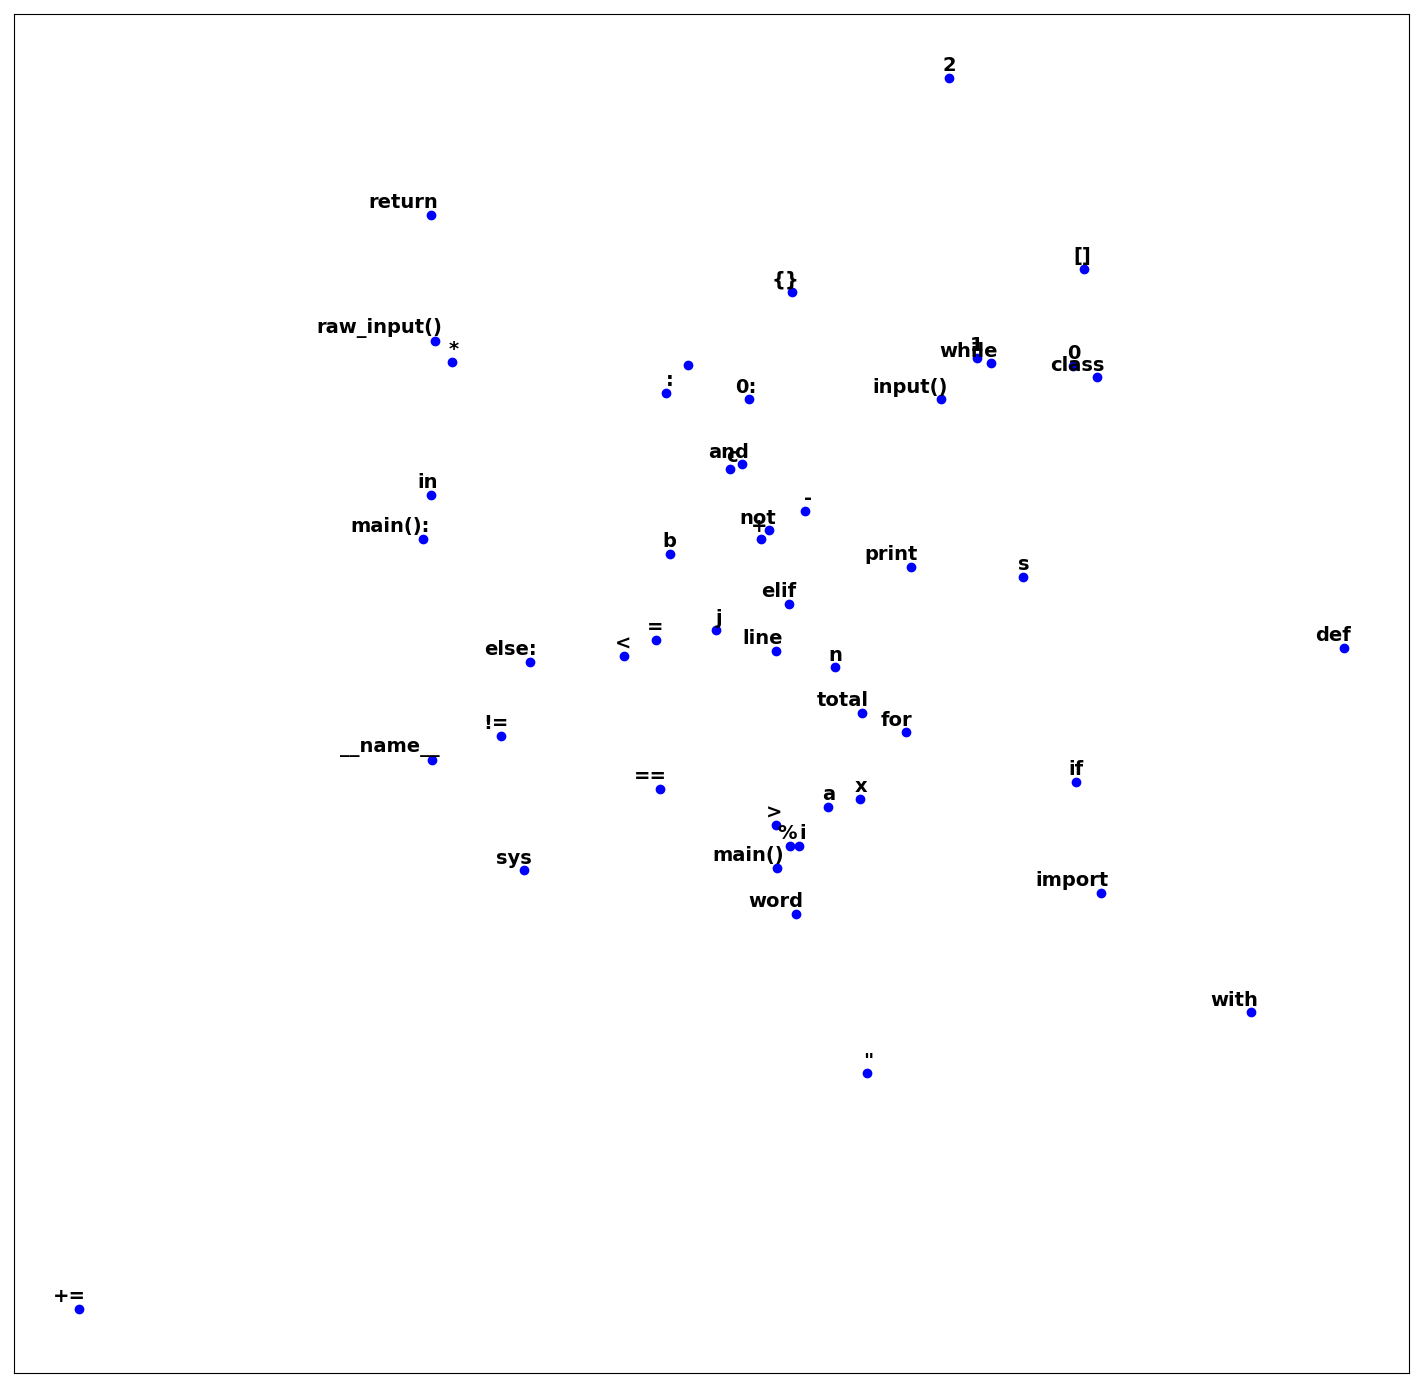

In [53]:
plot_embeddings(pca, id_to_word, top_words, figsize=(18, 18))

Measure the distance between vectors:

In [54]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, word1, word2):
    
    print euclidean(embeddings[word_t.word_index[word1]], 
                    embeddings[word_t.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, word1, word2):
    
    print cosine(embeddings[word_t.word_index[word1]], 
                    embeddings[word_t.word_index[word2]])

In [55]:
get_vector_distance(embeddings, '<', '>')

1.10842490196


In [56]:
get_vector_cosine_distance(embeddings, '<', '>')

0.810747383398


In [57]:
get_vector_distance(embeddings, '==', '!=')

1.14946496487


In [58]:
get_vector_distance(embeddings, 'if', 'elif')

1.10935497284


In [59]:
get_vector_distance(embeddings, 'elif', 'else:')

1.09822249413


In [66]:
get_vector_cosine_distance(embeddings, 'elif', 'else:')

0.914817500954


In [60]:
get_vector_distance(embeddings, '+', '-')

1.02021193504


In [61]:
get_vector_distance(embeddings, '<', '>')

1.10842490196


In [62]:
get_vector_distance(embeddings, 'for', 'while')

1.43049836159


In [63]:
get_vector_distance(embeddings, 'def', 'import')

1.34204411507


## 2) Programs as tokens

In [64]:
from tokenize import generate_tokens
from StringIO import StringIO

In [65]:
token_ids = []
token_words = []
token_labels = []
i = 0
while i < len(docs):
    doc = docs[i]
    label = labels[i]
    try:
        tokens = [(t[0], t[1]) for t in list(generate_tokens(StringIO(doc).readline))]
        # Token ID
        token_ids.append(
            [token[0] for token in tokens]
        )
        # Token
        token_words.append(
            [token[1] for token in tokens]
        )
        token_labels.append(
            label
        )
    except:
        pass
    i += 1

### 2.1) Token words

In [67]:
'Number encoded docs: {:,}'.format(len(token_words))

'Number encoded docs: 472,087'

In [68]:
token_docs = [
    ' '.join(array) for array in token_words
]

In [69]:
token_t = get_tokenizer()

token_t.fit_on_texts(token_docs)

In [70]:
# saving
with open('token_tokenizer.pickle', 'wb') as handle:
    pickle.dump(token_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
token_sequences = token_t.texts_to_sequences(token_docs)

id_to_token = { v: k for k, v in token_t.word_index.items() }

token_padded_docs = pad_sequences(token_sequences, maxlen=MAX_LENGTH, padding='post')

In [72]:
token_model = get_model()

token_model.fit(token_padded_docs, 
                token_labels,
                batch_size=128,
                epochs=10,
                validation_split=0.2)

token_loss, token_accuracy = token_model.evaluate(token_padded_docs, token_labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (token_accuracy * 100, token_loss * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 377669 samples, validate on 94418 samples
Epoch 1/10
377669/377669 [==============================] - 21s 56us/step - loss: 0.5770 - acc: 0.6929 - val_loss: 0.6516 - val_acc: 0.6544
Epoch 2/10
377669/377669 [==============================] - 27s 70us/step - loss: 0.5103 - acc: 0.7441 - val_loss: 0.6798 - val_acc: 0.6641
Epoch 3/10
377669/377669 [==============================] - 21s 

In [73]:
token_embeddings = get_embeddings(token_model)

token_embeddings[0]

Embedding Layer shape: (2000, 100)


array([-0.01055515,  0.03932968, -0.20109785,  0.04459779, -0.01213552,
        0.02679   ,  0.05189174,  0.02330291, -0.01300262, -0.04086259,
       -0.05366826,  0.00316867, -0.00117026, -0.06697028, -0.03076968,
       -0.03458051, -0.00137264,  0.04836617,  0.00889184,  0.01809986,
        0.16450976, -0.06157924,  0.0400925 , -0.04922886,  0.04551181,
       -0.0381777 , -0.0566081 , -0.09103033,  0.039715  , -0.095396  ,
       -0.01149747, -0.04587183, -0.12301635,  0.03985543, -0.17540309,
        0.01413623, -0.0357413 ,  0.08482008, -0.00522294, -0.04924323,
       -0.04130581, -0.27276483, -0.14571881, -0.00320675,  0.0389657 ,
        0.112365  , -0.05469406,  0.04341209,  0.00401764, -0.04262449,
       -0.13171329,  0.00267196,  0.03251458,  0.11026194, -0.0430258 ,
        0.06018998,  0.06111359, -0.01540516, -0.00654152, -0.02071267,
        0.04201894, -0.00672896, -0.01685001,  0.06553598,  0.00409818,
        0.16257314, -0.00293159,  0.01966054,  0.01748792, -0.03

In [74]:
np.save('data/processed/token_embeddings', token_embeddings)

In [75]:
token_pca = get_pca(token_embeddings)

token_top_words = get_top_words(token_t, N=100)

PCA explained variance ratio: [ 0.14704455  0.04765156] Total: 0.194696117193


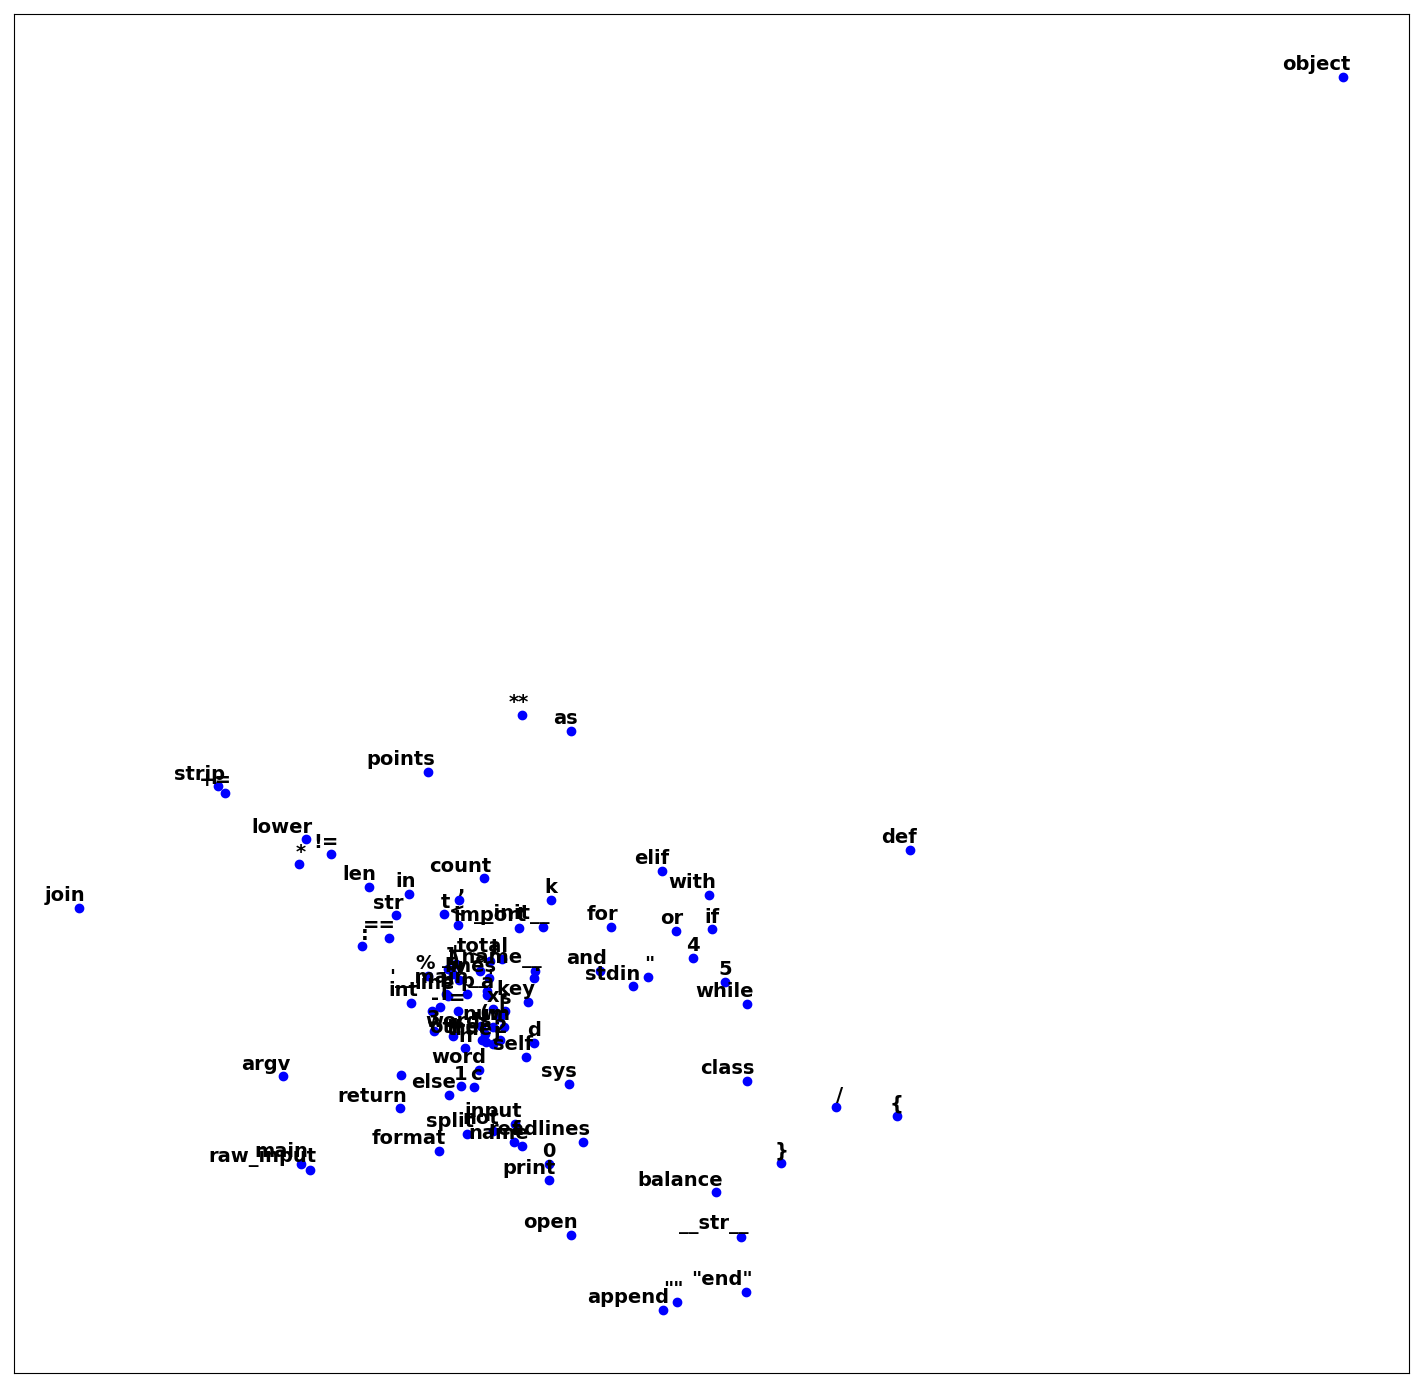

In [76]:
plot_embeddings(token_pca, id_to_token, token_top_words, figsize=(18, 18))

In [77]:
get_vector_distance(token_embeddings, '<', '>')

1.11708831787


In [88]:
get_vector_cosine_distance(token_embeddings, '<', '>')

0.81622379862


In [78]:
get_vector_distance(token_embeddings, '+', '-')

1.09004557133


In [89]:
get_vector_cosine_distance(token_embeddings, '+', '-')

0.961658675566


In [79]:
get_vector_distance(token_embeddings, '==', '!=')

1.04707372189


In [80]:
get_vector_distance(token_embeddings, 'if', 'elif')

1.00951552391


In [90]:
get_vector_cosine_distance(token_embeddings, 'if', 'elif')

1.02141484385


In [92]:
get_vector_distance(token_embeddings, 'elif', 'else')

3.22985672951


In [93]:
get_vector_cosine_distance(token_embeddings, 'elif', 'else')

1.1202900115


In [82]:
get_vector_distance(token_embeddings, '*', '/')

1.22836315632


In [83]:
get_vector_distance(token_embeddings, 'for', 'while')

0.759491324425


In [94]:
get_vector_cosine_distance(token_embeddings, 'for', 'while')

0.753740799685


In [84]:
get_vector_distance(token_embeddings, '{', '[')

2.87245893478


In [95]:
get_vector_cosine_distance(token_embeddings, '{', '[')

0.908496698006


In [85]:
get_vector_distance(token_embeddings, '}', ']')

3.02394962311


In [96]:
get_vector_cosine_distance(token_embeddings, '}', ']')

1.10425471289


In [86]:
get_vector_distance(token_embeddings, '[', ']')

3.43188476562


In [97]:
get_vector_cosine_distance(token_embeddings, '[', ']')

1.17339880029


In [87]:
get_vector_distance(token_embeddings, '(', ')')

4.10358142853


In [99]:
get_vector_cosine_distance(token_embeddings, '{', '}')

0.839593571462


In [100]:
get_vector_cosine_distance(token_embeddings, '(', ')')

1.14251427162


### 2.2) Token categories

In [ ]:
'Number encoded docs: {:,}'.format(len(token_ids))

In [101]:
token_ids = [
    ' '.join([str(a) for a in array]) for array in token_ids
]

In [102]:
category_t = get_tokenizer()

category_t.fit_on_texts(token_ids)

In [103]:
# saving
with open('category_tokenizer.pickle', 'wb') as handle:
    pickle.dump(category_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [104]:
category_sequences = category_t.texts_to_sequences(token_ids)

id_to_category = { v: k for k, v in category_t.word_index.items() } # GET THE NAMES here for each category number?

category_padded_docs = pad_sequences(category_sequences, maxlen=MAX_LENGTH, padding='post')

In [105]:
category_model = get_model()

category_model.fit(category_padded_docs, 
                   token_labels,
                   batch_size=128,
                   epochs=10,
                   validation_split=0.2)

cat_loss, cat_accuracy = token_model.evaluate(category_padded_docs, token_labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (token_accuracy * 100, token_loss * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 377669 samples, validate on 94418 samples
Epoch 1/10
377669/377669 [==============================] - 21s 57us/step - loss: 0.6665 - acc: 0.5995 - val_loss: 0.6476 - val_acc: 0.6367
Epoch 2/10
377669/377669 [==============================] - 24s 63us/step - loss: 0.6637 - acc: 0.6011 - val_loss: 0.6496 - val_acc: 0.6330
Epoch 3/10
377669/377669 [==============================] - 28s 

In [106]:
category_embeddings = get_embeddings(category_model)

category_embeddings[0]

Embedding Layer shape: (2000, 100)


array([ -3.51493596e-03,   9.93889943e-03,  -1.69155132e-02,
        -6.44906145e-03,   7.79897615e-04,  -6.05487870e-03,
         1.12560224e-02,   1.38450030e-03,  -1.23075088e-02,
         4.05435637e-03,  -1.29941106e-03,  -7.82100484e-03,
        -2.86172424e-03,  -1.23041300e-02,   1.54275084e-02,
         6.57628570e-03,   9.76383220e-03,  -6.35060063e-03,
         1.57574285e-03,   3.89358820e-03,   5.28406678e-03,
        -1.93760521e-03,   2.13804580e-02,   9.60721821e-02,
         2.47851340e-03,  -5.00512822e-03,   5.57676889e-03,
         1.60182249e-02,   9.77674033e-03,  -1.98882408e-02,
        -2.96946429e-03,  -1.42764766e-02,   2.30843760e-03,
         6.72800886e-03,   3.57672409e-03,  -2.91141379e-03,
        -5.40186279e-03,   1.91203728e-02,  -1.46855600e-02,
        -1.81595553e-02,   3.42029370e-02,  -8.98190495e-03,
        -1.28607433e-02,  -5.98766562e-03,  -2.06412165e-03,
         2.30280799e-03,  -9.01798625e-03,  -1.03087043e-02,
        -1.08823711e-02,

In [107]:
np.save('data/processed/token_category_embeddings', category_embeddings)

In [109]:
category_pca = get_pca(category_embeddings)

PCA explained variance ratio: [ 0.29676294  0.02943139] Total: 0.326194334775


In [110]:
category_top_words = get_top_words(category_pca, N=100)

AttributeError: 'numpy.ndarray' object has no attribute 'word_counts'

## 3) Programs as Abstract Syntax Trees

In [62]:
# TODO

## SCORE

In [128]:
scores = {
    'Word NN': (word_loss, word_accuracy),
    'Word Token NN': (token_loss, token_accuracy),
    #'Category Token NN': (token_loss, token_accuracy),
    #'AST NN': (ast_loss, ast_accuracy),
}

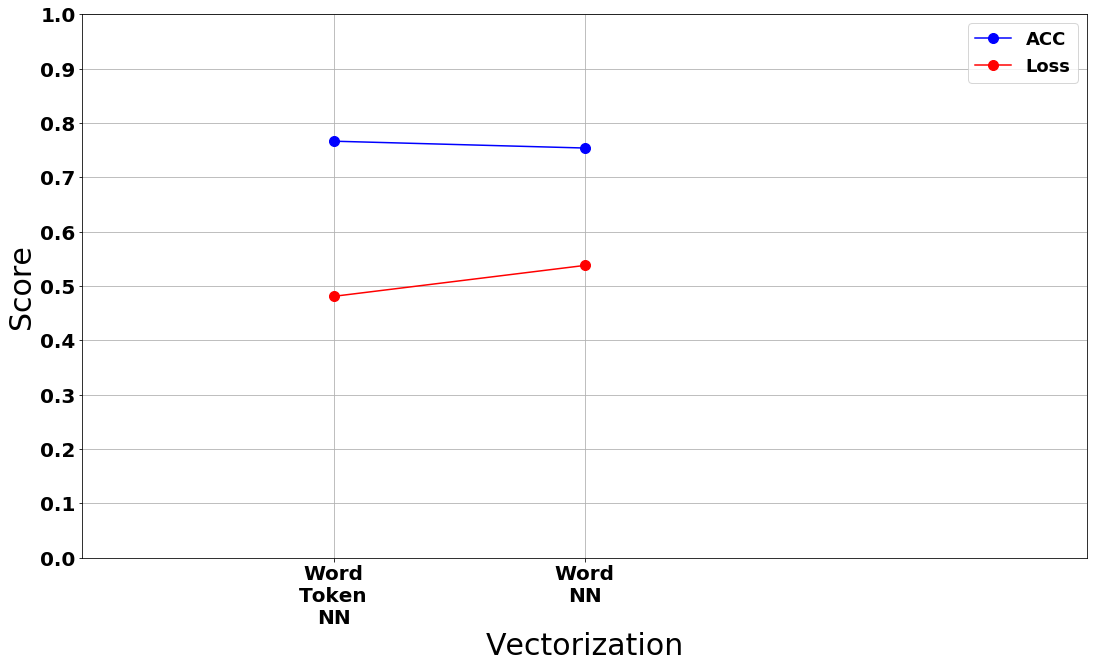

In [129]:
x = range(len(scores))
acc = [v[1] for k, v in scores.items()]
loss = [v[0] for k, v in scores.items()]
keys = [k.replace(' ', '\n') for k, v in scores.items()]

plt.subplots(figsize=(18, 10))
plt.grid()
plt.plot(x, acc, 'o-', color='b', label='ACC', markersize=10)
plt.plot(x, loss, 'o-', color='red', label='Loss', markersize=10)
plt.ylabel('Score', fontsize=30)
plt.xlabel('Vectorization', fontsize=30)
plt.xlim([-1, len(scores) + 1])
plt.xticks(x, keys)
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="upper right", fontsize=18)